In [ ]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from fastprogress import progress_bar,master_bar
from miniai.datasets import *
from miniai.training import *
from miniai.conv import *

In [ ]:
from fastcore.test import test_close
from typing import List

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

## Data

Get FashionMnist dataset from HF

In [ ]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name, ignore_verifications=True)

  0%|          | 0/2 [00:00<?, ?it/s]

Create an inplace transforms to cast each image inside a dictionary to a tensor.

In [ ]:
@inplace
def transformi(b: dict[str, List[int]]): 
    b[x] = [TF.to_tensor(o) for o in b[x]]

In [ ]:
bs = 256
tds = dsd.with_transform(transformi)

Grab first image from a training dataset and show it

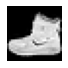

In [ ]:
ds = tds['train']
img = ds[0]['image']
show_image(img, figsize=(1,1));

In [ ]:
# Reminder how `collate_dict` works
cf = collate_dict(ds)

In [ ]:
o = [{'image': 1, 'label': 2}, {'image': 3, 'label': 4}]
cf(o)

(tensor([1, 3]), tensor([2, 4]))

In [ ]:
# combine moving to device with collate function
def collate_(b): return to_device(cf(b))

# return data_loaders for each of the items in a Dataset
def data_loaders(dsd, bs, **kwargs): return {k:DataLoader(v, bs, **kwargs) for k,v in dsd.items()}

In [ ]:
dls = data_loaders(tds, bs, collate_fn=collate_)

In [ ]:
dt = dls['train']
dv = dls['test']

xb,yb = next(iter(dt))

In [ ]:
labels = ds.features[y].names

In [ ]:
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Create a label getter using `itemgetter` for target values and lookup them in labels list. Show the resulting titles.

In [ ]:
lbl_getter = itemgetter(*yb[:16])
titles = lbl_getter(labels)

Show images in a grid using `show_images`

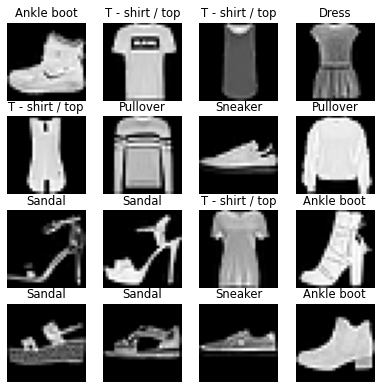

In [ ]:
mpl.rcParams['figure.dpi'] = 70
show_images(xb[:16], imsize=1.7, titles=titles)

## Warmup - classify

In [ ]:
from torch import optim

bs = 256
lr = 0.4

Create a sequential model with filters (1-16-10). Get SGD optimizer, calculate loss and accuracy

In [ ]:
cnn = nn.Sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    conv(16,10, act=False),
    nn.Flatten()).to(def_device)

In [ ]:
opt = optim.SGD(cnn.parameters(), lr=lr)
loss,acc = fit(5, cnn, F.cross_entropy, opt, dt, dv)

0 0.7232040642738342 0.7435
1 0.52378122549057 0.8108
2 0.4928600333690643 0.8232
3 0.42600515835285185 0.848
4 0.4011297644615173 0.8585


This takes quite some time because each image is being converted one by one into a tensor and all of the work is done just by a single cpu.

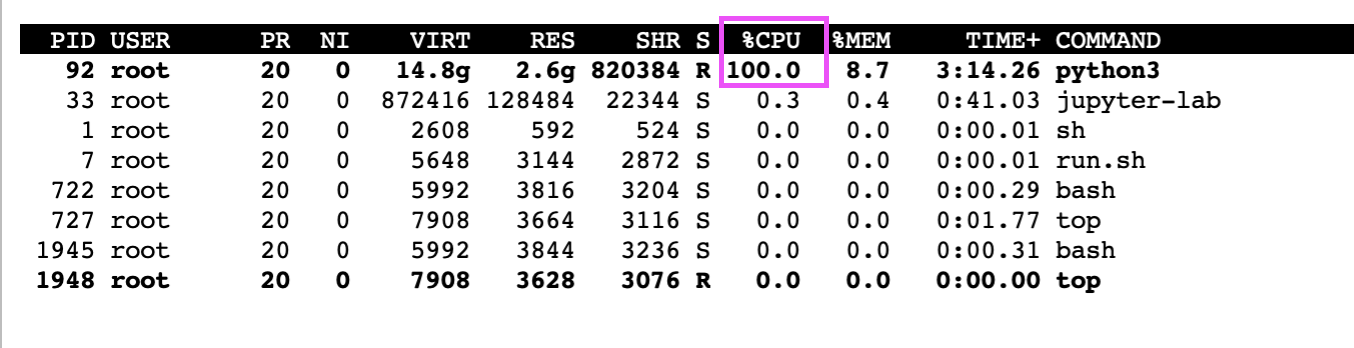

Unfortunately little can be done about this without rewriting the `fit` function.

In [ ]:
dsd['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

## Autoencoder

For the autoencoder we want to create a pipeline that applies convolutions to reduce image size and that apply deconvolutions (UpsamplingNearest2d) to return our initial image. A well trained model will result in an image that is very similar to the initial one.

UpsamplingNearest2d copies each pixel given number of times effectively increasing the image size.

In [ ]:
# Input tensor
inp = torch.randn(1, 3, 4, 4)  # (batch_size, channels, height, width)

# Upsample by a factor of 2 using size
upsample = nn.UpsamplingNearest2d(size=(8, 8))
output = upsample(inp)  # Output size: (1, 3, 8, 8)

In [ ]:
inp

tensor([[[[-0.06,  1.33,  0.74, -0.98],
          [-1.27,  0.23, -1.99, -0.53],
          [-0.75,  0.04, -0.35, -1.36],
          [ 0.32,  0.43, -1.40, -1.35]],

         [[ 0.91,  1.28, -0.02, -0.19],
          [ 0.20, -1.47,  1.08, -1.73],
          [-1.13, -1.53,  0.30,  0.44],
          [ 2.86,  1.71, -0.21,  0.11]],

         [[-0.43, -0.85,  1.47, -1.20],
          [-0.07, -0.63,  0.09,  0.72],
          [ 0.17,  1.87,  0.48, -0.55],
          [ 0.73,  1.88, -0.43,  1.50]]]])

In [ ]:
output

tensor([[[[-0.06, -0.06,  1.33,  1.33,  0.74,  0.74, -0.98, -0.98],
          [-0.06, -0.06,  1.33,  1.33,  0.74,  0.74, -0.98, -0.98],
          [-1.27, -1.27,  0.23,  0.23, -1.99, -1.99, -0.53, -0.53],
          [-1.27, -1.27,  0.23,  0.23, -1.99, -1.99, -0.53, -0.53],
          [-0.75, -0.75,  0.04,  0.04, -0.35, -0.35, -1.36, -1.36],
          [-0.75, -0.75,  0.04,  0.04, -0.35, -0.35, -1.36, -1.36],
          [ 0.32,  0.32,  0.43,  0.43, -1.40, -1.40, -1.35, -1.35],
          [ 0.32,  0.32,  0.43,  0.43, -1.40, -1.40, -1.35, -1.35]],

         [[ 0.91,  0.91,  1.28,  1.28, -0.02, -0.02, -0.19, -0.19],
          [ 0.91,  0.91,  1.28,  1.28, -0.02, -0.02, -0.19, -0.19],
          [ 0.20,  0.20, -1.47, -1.47,  1.08,  1.08, -1.73, -1.73],
          [ 0.20,  0.20, -1.47, -1.47,  1.08,  1.08, -1.73, -1.73],
          [-1.13, -1.13, -1.53, -1.53,  0.30,  0.30,  0.44,  0.44],
          [-1.13, -1.13, -1.53, -1.53,  0.30,  0.30,  0.44,  0.44],
          [ 2.86,  2.86,  1.71,  1.71, -0.21, 

In [ ]:
def deconv(ni, nf, ks=3, act=True):
    # UpsamplingNearest2d followed by stride-1 convolution for training the weights
    layers = [nn.UpsamplingNearest2d(scale_factor=2),
              nn.Conv2d(ni, nf, stride=1, kernel_size=ks, padding=ks//2)]
    # optionally followed by activation layer
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [ ]:
def eval(model, loss_func, valid_dl, epoch=0):
    # set model to evaluation mode and calculate loss on a validation dataset
    # target is the image itself
    model.eval()
    with torch.no_grad():
        tot_loss,count = 0.,0
        for xb,_ in valid_dl:
            pred = model(xb)
            n = len(xb)
            count += n
            tot_loss += loss_func(pred,xb).item()*n
    print(epoch, f'{tot_loss/count:.3f}')

In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    # training part of the loop
    for epoch in range(epochs):
        model.train()
        for xb,_ in train_dl:
            loss = loss_func(model(xb), xb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        # evaluation part of the loop
        eval(model, loss_func, valid_dl, epoch)

In [ ]:
# sample autoencoder model.
# keep note of the shapes used 
ae = nn.Sequential(   #28x28
    nn.ZeroPad2d(2),  #32x32
    conv(1,2),        #16x16
    conv(2,4),        #8x8
#     conv(4,8),        #4x4
#     deconv(8,4),      #8x8
    deconv(4,2),      #16x16
    deconv(2,1, act=False), #32x32
    nn.ZeroPad2d(-2), #28x28
    nn.Sigmoid()
).to(def_device)

In [ ]:
eval(ae, F.mse_loss, dv)

0 0.181


In [ ]:
opt = optim.SGD(ae.parameters(), lr=0.1)
fit(5, ae, F.mse_loss, opt, dt, dv)

0 0.071
1 0.037
2 0.030
3 0.027
4 0.025


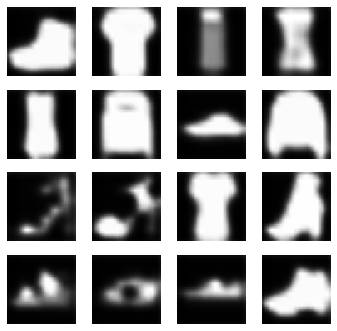

In [ ]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

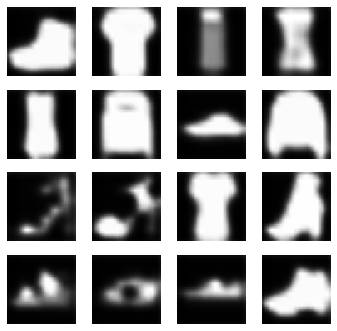

In [ ]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

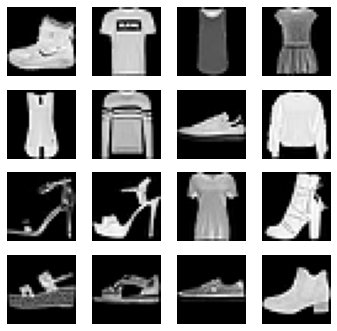

In [ ]:
show_images(xb[:16].data.cpu(), imsize=1.5)